In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [60]:
stock=yf.download("TCS.BO",period="10y",actions=True)
stock

C:\Users\Omkar Singh\Documents\Regression\.venv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2014-02-24,1103.000000,1103.000000,1085.599976,1089.099976,871.011169,181384,0.0,0.0
2014-02-25,1095.000000,1099.849976,1090.750000,1094.150024,875.050110,105698,0.0,0.0
2014-02-26,1095.500000,1097.500000,1089.275024,1091.199951,872.690613,69202,0.0,0.0
2014-02-28,1084.000000,1138.500000,1080.000000,1136.400024,908.839355,293910,0.0,0.0
2014-03-03,1135.000000,1148.449951,1116.599976,1120.425049,896.063477,131848,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-02-16,4112.049805,4147.000000,4100.899902,4129.200195,4129.200195,132816,0.0,0.0
2024-02-19,4119.149902,4121.649902,4055.100098,4101.600098,4101.600098,56840,0.0,0.0
2024-02-20,4089.899902,4098.850098,4011.100098,4029.949951,4029.949951,30284,0.0,0.0


<Axes: xlabel='Date', ylabel='Close'>

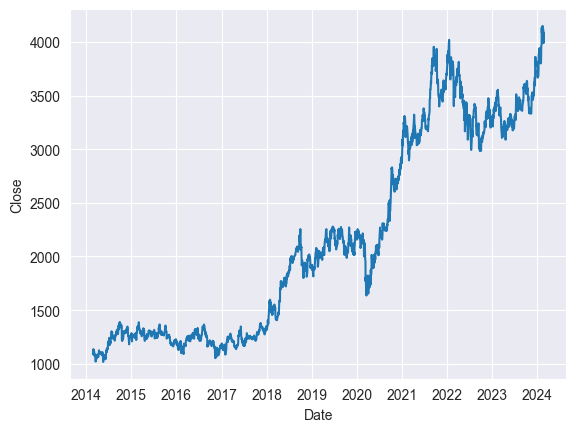

In [61]:
sns.lineplot(data=stock,x="Date",y="Close")

In [62]:
features = ['Open','Close','Volume']
df = stock[features]

In [63]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
window_size = 60

In [64]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size, -1])
    return np.array(X), np.array(y)

In [65]:
X, y = create_dataset(scaled_data, window_size)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [66]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

In [67]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/50
60/60 [==============================] - 4s 20ms/step - loss: 0.0034
Epoch 2/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 3/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 4/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 5/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 6/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 7/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 8/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 9/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 10/50
60/60 [==============================] - 1s 21ms/step - loss: 0.0029
Epoch 11/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 12/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0030
Epoch 13/50
60/60 [==================

In [68]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
#X_test_reshaped = X_test[:, -1, :-1].reshape(-1, len(features) - 1)
predicted_data = np.concatenate((X_test_reshaped, predictions), axis=1)
predicted_data = scaler.inverse_transform(predicted_data)
predictions = predicted_data[:, -1]

15/15 [==============================] - 1s 10ms/step


plt.figure(figsize=(10, 6))
plt.plot(df.index[split + window_size:], scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Close Price')
plt.plot(df.index[split + window_size:], predictions, label='Predicted Close Price')
plt.title('True vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

ValueError: non-broadcastable output operand with shape (477,1) doesn't match the broadcast shape (477,3)